In [233]:
%load_ext autoreload
%autoreload 2

from msr.training.data.datasets import PtbXLDataset
from msr.training.data.datamodules import PtbXLDataModule
from msr.training.trainers import MLClassifierTrainer, MLRegressorTrainer
from msr.data.raw.ptbxl import FS
from msr.evaluation.plotters import MatplotlibPlotter, PlotlyPlotter
from msr.evaluation.visualisations import matplotlib_preds_vs_target
from msr.evaluation.loggers import BaseWandbLogger

TARGET = "diagnostic_class"
BASE_PARAMS = dict(fs=FS, target=TARGET)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
rep_type = "whole_signal_features"
dm = PtbXLDataModule(rep_type, **BASE_PARAMS)
dm.setup()

In [240]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=20)
ml_trainer = MLRegressorTrainer(model, dm)
ml_trainer.fit()

In [241]:
plotter = PlotlyPlotter()
logger = BaseWandbLogger(PROJECT, run_name="logger_regressor")

A Jupyter Widget

A Jupyter Widget

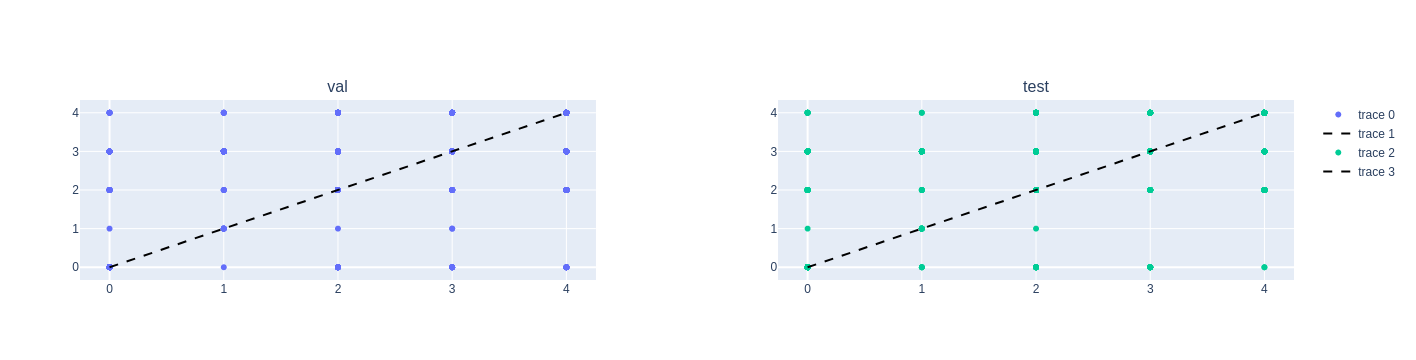

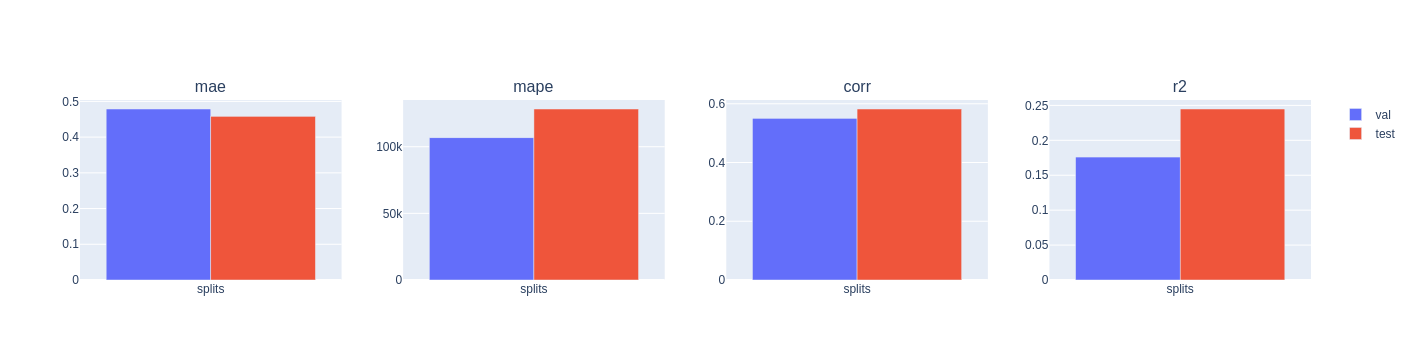

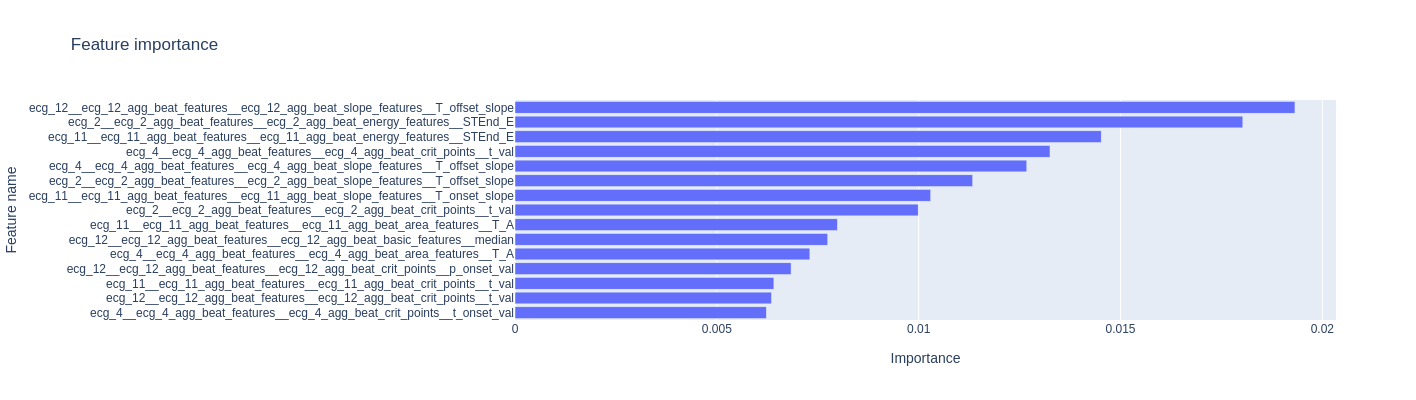

A Jupyter Widget

In [242]:
results = ml_trainer.evaluate(plotter, logger=logger)

In [106]:
wandb.init(PROJECT)

A Jupyter Widget

A Jupyter Widget

In [107]:
wandb.log(figs)

In [108]:
wandb.finish()

A Jupyter Widget

In [26]:
logger = WandbLogger(project=PROJECT, run_name='test')

A Jupyter Widget

A Jupyter Widget